In [1]:
import os
from zipfile import ZipFile
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
def load_har_dataset(url, extract_path: Path, filename: str, overwrite=False):
    # check if existed already
    filepath = extract_path / filename
    if filepath.exists() and not overwrite:
        print("The dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    with open(filepath, 'wb') as f:
        f.write(response.content)

    with ZipFile(filepath, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall(extract_path)

In [14]:
FILE_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
FILE_NAME = "UCI HAR Dataset.zip"
DATA_PATH = ("C:/Users/nuke/Desktop/mlcourses/UCIHARDataset.zip")

# load_har_dataset(url=FILE_URL, extract_path=DATA_PATH, filename=FILE_NAME)

PATH_TO_SAMSUNG_DATA = DATA_PATH

In [15]:
PATH_TO_SAMSUNG_DATA

'C:/Users/nuke/Desktop/mlcourses/UCIHARDataset.zip'

In [24]:
import zipfile
import numpy as np
archive = zipfile.ZipFile(PATH_TO_SAMSUNG_DATA, "r")
with archive as ar:
    # ar.printdir()
    X_train = np.loadtxt(ar.extract("UCI HAR Dataset/train/X_train.txt"))
    y_train = np.loadtxt(ar.extract("UCI HAR Dataset/train/y_train.txt")).astype(int)

    X_test = np.loadtxt(ar.extract("UCI HAR Dataset/test/X_test.txt"))
    y_test = np.loadtxt(ar.extract("UCI HAR Dataset/test/y_test.txt")).astype(int)

In [25]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

In [67]:
type(X_train)

numpy.ndarray

In [72]:
# merging two vectors 
x = np.concatenate((X_train, X_test), axis=0)

numpy.ndarray

In [73]:
y = np.concatenate((y_train, y_test), axis=0)

In [74]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [75]:
n_classes = np.unique(y).size
n_classes

6



    1 – walking

    2 – walking upstairs

    3 – walking downstairs

    4 – sitting

    5 – standing

    6 – laying down


In [77]:
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()
x_scaled = SS.fit_transform(x)

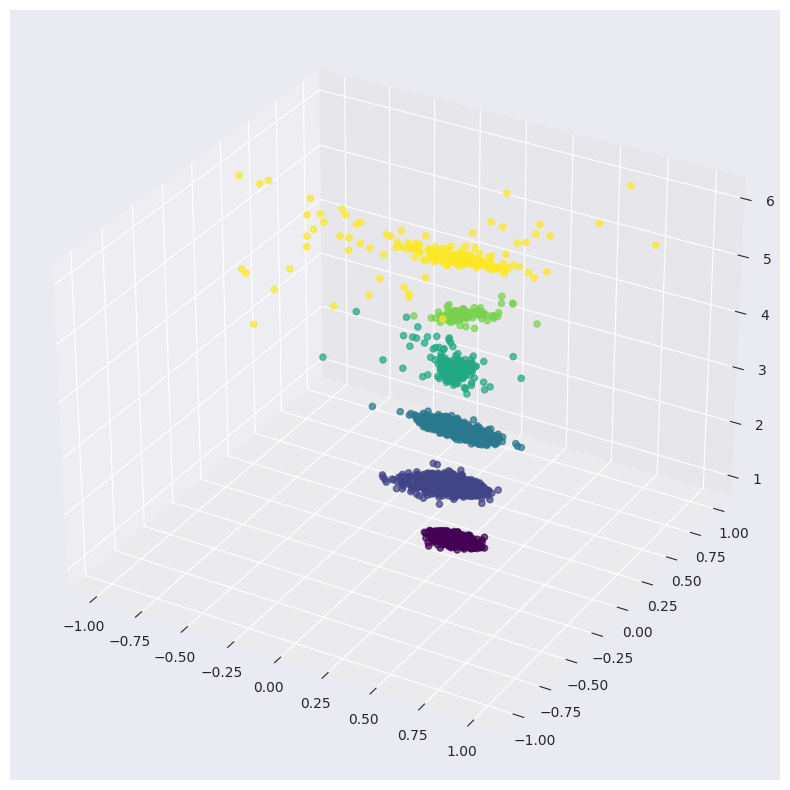

In [80]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0],x[:, 1], y[:], c=y, cmap='viridis', alpha=0.7)

C:\Users\nuke\AppData\Local\Temp\ipykernel_33340\2521676579.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[:, 0],x[:, 1], cmap='viridis', alpha=0.7)


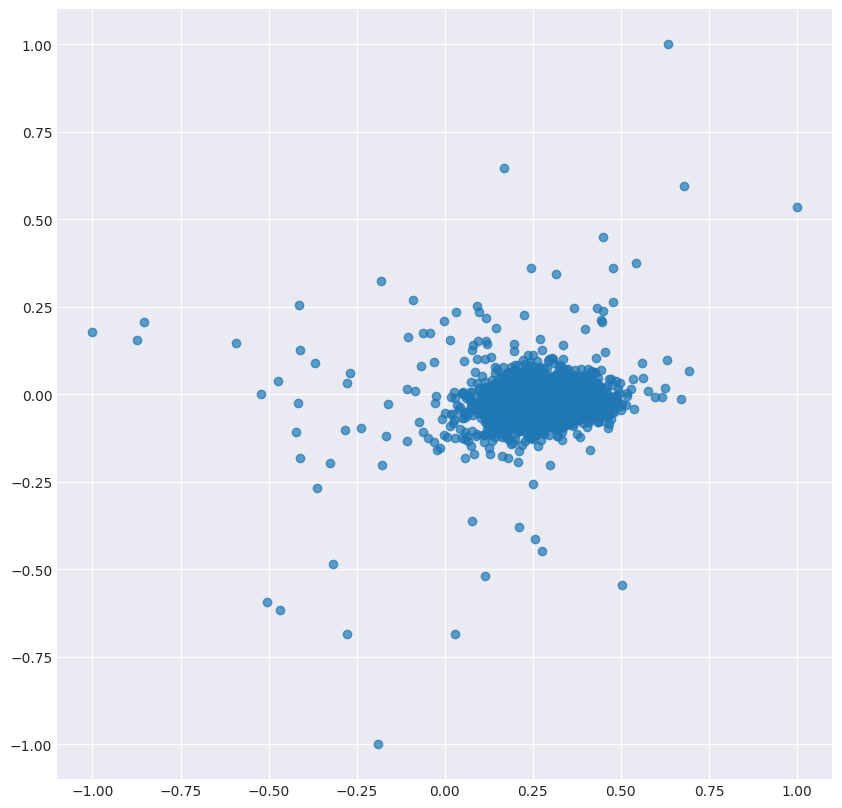

In [83]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(x[:, 0],x[:, 1], cmap='viridis', alpha=0.7)

 What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data? (65
)

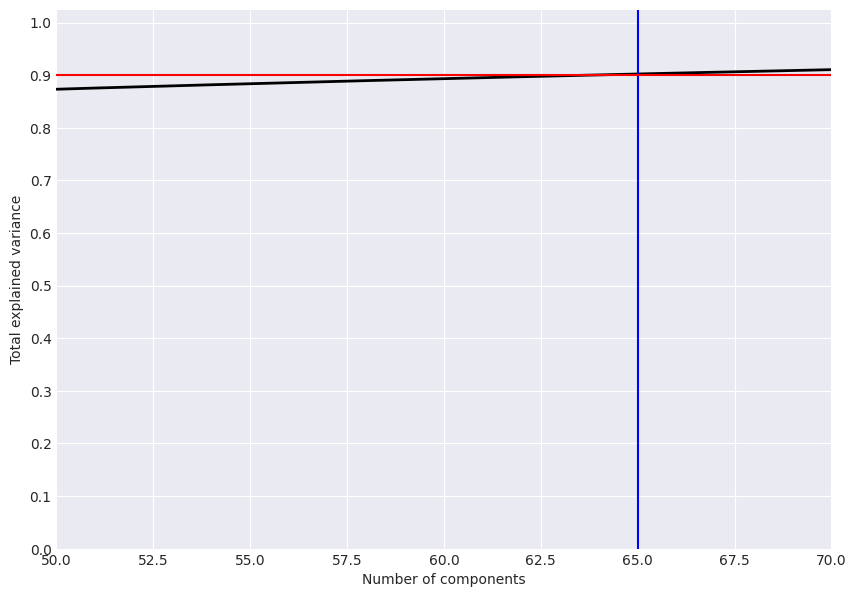

In [100]:
from sklearn import decomposition

pca = decomposition.PCA(random_state=RANDOM_STATE).fit(x_scaled)
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color="k", lw=2)
plt.xlabel("Number of components")
plt.ylabel("Total explained variance")
plt.xlim(50, 70)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(65, c="b")
plt.axhline(0.9, c="r")
plt.show();

 What percentage of the variance is covered by the first principal component? Round to the nearest percent.(51)

In [102]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.50738221 0.56977407 0.59669971 0.62122842 0.64011777 0.65643173
 0.67057706 0.68273917 0.69259164 0.70208392 0.71066696 0.71876676
 0.72642539 0.73319206 0.73949448 0.74565165 0.751605   0.75737696
 0.76301127 0.76841957 0.77360785 0.77863527 0.78336756 0.78800575
 0.79247423 0.79687291 0.80104154 0.80504963 0.80894035 0.81275373
 0.81642243 0.82006601 0.82355825 0.82702561 0.830381   0.83367511
 0.83691335 0.83991843 0.84286097 0.84576549 0.84852314 0.85122179
 0.85386374 0.85644405 0.85899435 0.86147211 0.86392749 0.86631039
 0.86866941 0.87098985 0.87327345 0.87546527 0.87759158 0.87968303
 0.88171782 0.88372949 0.8857106  0.88765451 0.8895796  0.89147499
 0.89333902 0.89516825 0.89697782 0.89874146 0.90048333 0.90219804
 0.90390845 0.90558298 0.90722001 0.90883447 0.9104374  0.9120033
 0.91350564 0.91499366 0.91647968 0.91792957 0.91937372 0.92079514
 0.92220344 0.92357467 0.92490816 0.92623684 0.92754834 0.92883283
 0.93010695 0.93135118 0.9325653  0.93376531 0.93495553 0.93611

If everything worked out correctly, you will see a number of clusters, almost perfectly separated from each other. What types of activity are included in these clusters? Answer : 2 clusters: (walking, walking upstairs, walking downstairs ) and (sitting, standing, laying)

Projecting 561-dimensional data to 2D


C:\Users\nuke\AppData\Local\Temp\ipykernel_33340\1031912089.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("nipy_spectral", 10),


Text(0.5, 1.0, 'MNIST. PCA projection')

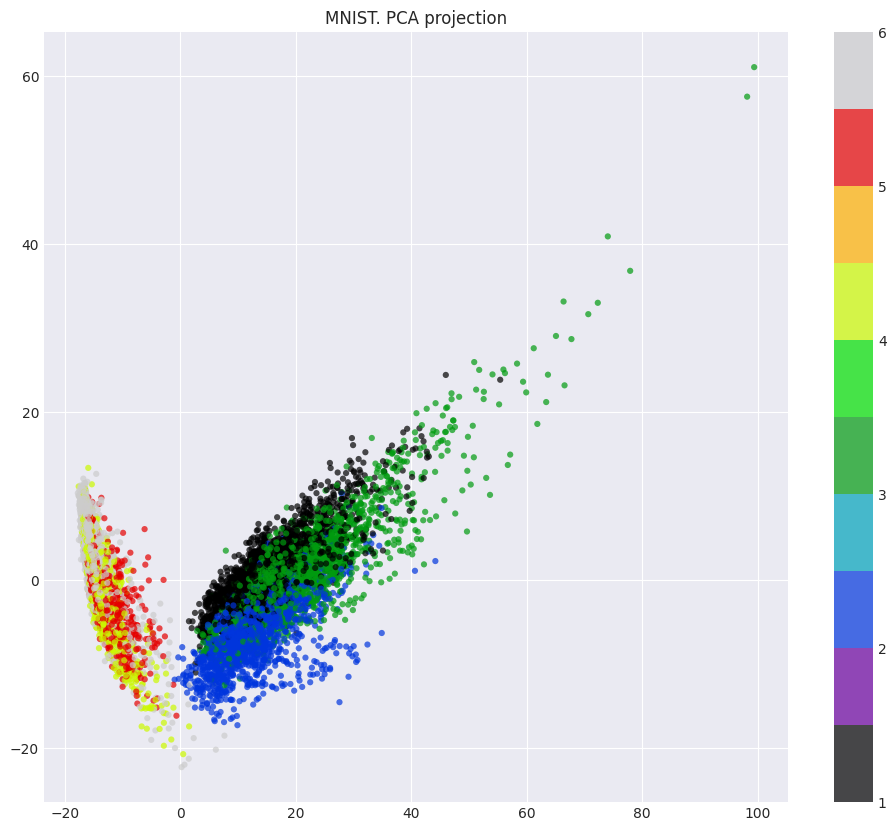

In [142]:
pca = decomposition.PCA(n_components=2).fit(x_scaled)
X_reduced = pca.transform(x_scaled)
print("Projecting %d-dimensional data to 2D" % x_scaled.shape[1])

plt.figure(figsize=(12, 10))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=20,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. PCA projection")

In [143]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.50738221 0.56977407]


CPU times: total: 4min
Wall time: 40.4 s


<timed exec>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


Text(0.5, 1.0, 'MNIST. t-SNE projection')

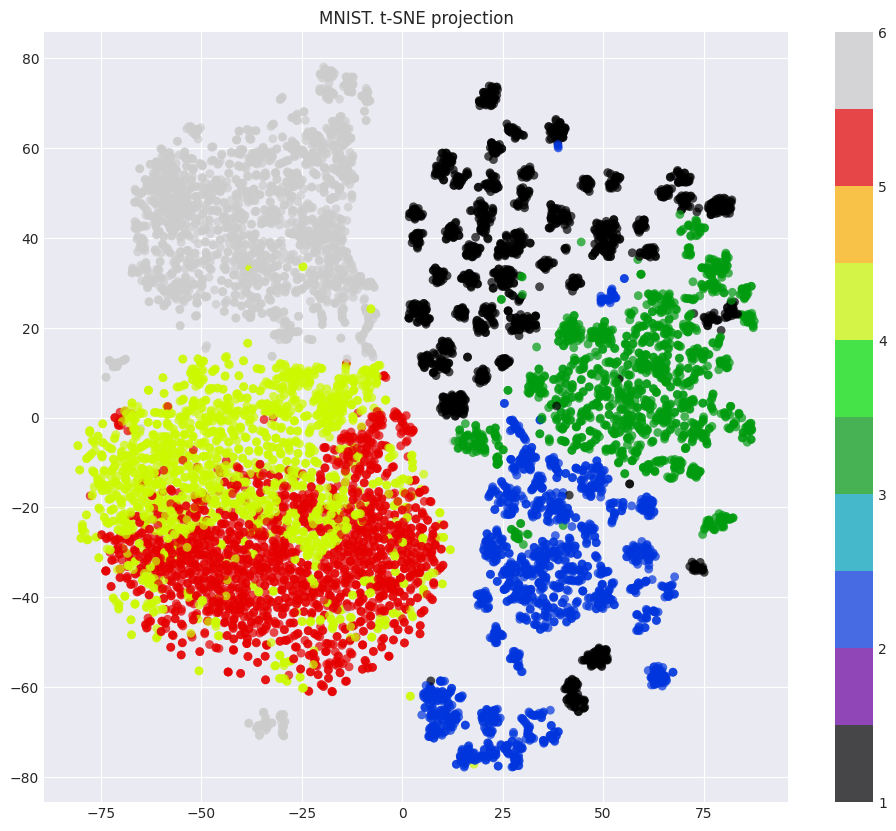

In [144]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(random_state=RANDOM_STATE)

X_tsne = tsne.fit_transform(x_scaled)

plt.figure(figsize=(12, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. t-SNE projection")

**Clustering**

In [108]:
from sklearn.cluster import KMeans

In [109]:
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100)

Projecting 561-dimensional data to 2D


Text(0.5, 1.0, 'KMeans projection')

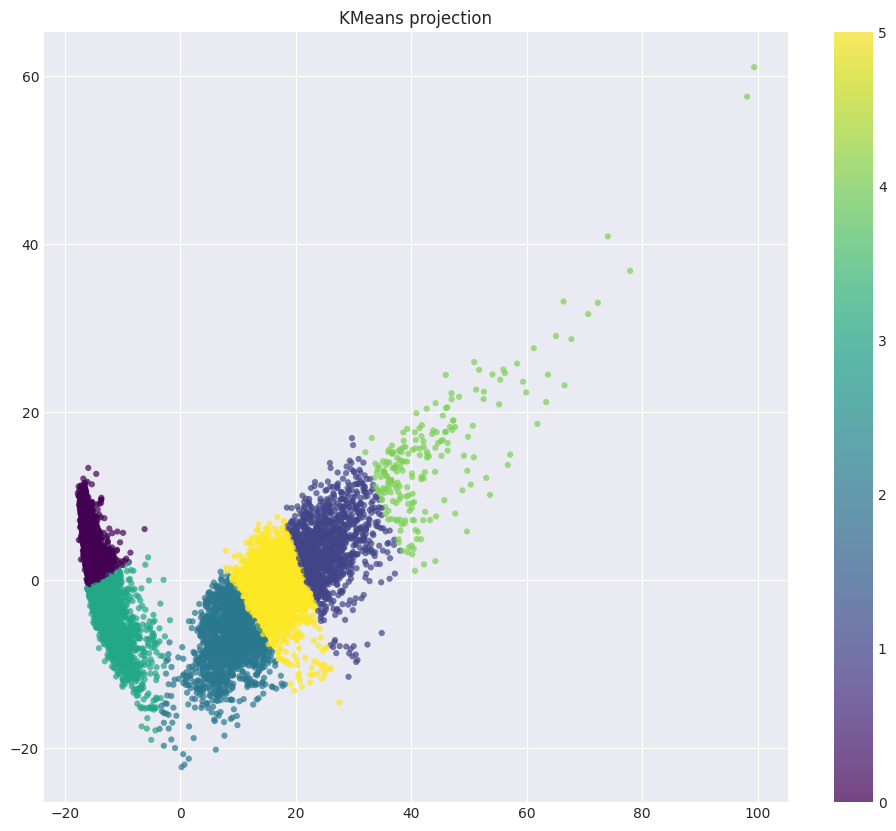

In [146]:

kmeans.fit(X_reduced)
print("Projecting %d-dimensional data to 2D" % x_scaled.shape[1])

plt.figure(figsize=(12, 10))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=kmeans.labels_,
    edgecolor="none",
    alpha=0.7,
    s=20,
    cmap='viridis',
)
plt.colorbar()
plt.title("KMeans projection")

In [126]:
X_reduced_k.shape

(10299, 6)

In [130]:
kmeans.

array([0, 0, 0, ..., 1, 1, 1])

In [136]:
print(X_reduced[0, 0], X_reduced[0, 1])

-16.380979818360757 1.9950834057639364


In [137]:
tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0,406,431,0,39,846,1722
going up the stairs,0,115,1011,0,2,416,1544
going down the stairs,0,586,162,0,162,496,1406
sitting,1117,0,15,645,0,0,1777
standing,972,0,2,932,0,0,1906
laying,1366,0,26,552,0,0,1944
all,3455,1107,1647,2129,203,1758,10299


He has searched a percentage like max_values_for_activities[:] devvided on all[:]/ for example 846 / 1722

In [ ]:
pd.Series(np.reshape(tab.iloc[:-1, :-1].max(axis=1).values, (6, 1)) / tab.iloc[:-1, 6].values, index=tab.index[:-1])

In [177]:
np.reshape(tab.iloc[:-1, :-1].max(axis=1).values, (6, 1))

array([[ 846],
       [1011],
       [ 586],
       [1117],
       [ 972],
       [1366]], dtype=int64)

In [167]:
np.reshape(tab.iloc[:-1, :-1].values, (36, 1))

array([[   0],
       [ 406],
       [ 431],
       [   0],
       [  39],
       [ 846],
       [   0],
       [ 115],
       [1011],
       [   0],
       [   2],
       [ 416],
       [   0],
       [ 586],
       [ 162],
       [   0],
       [ 162],
       [ 496],
       [1117],
       [   0],
       [  15],
       [ 645],
       [   0],
       [   0],
       [ 972],
       [   0],
       [   2],
       [ 932],
       [   0],
       [   0],
       [1366],
       [   0],
       [  26],
       [ 552],
       [   0],
       [   0]], dtype=int64)

In [155]:
tab.index[:-1]

Index(['walking', 'going up the stairs', 'going down the stairs', 'sitting',
       'standing', 'laying'],
      dtype='object')

In [175]:
tab.iloc[:, 6].values

array([ 1722,  1544,  1406,  1777,  1906,  1944, 10299], dtype=int64)

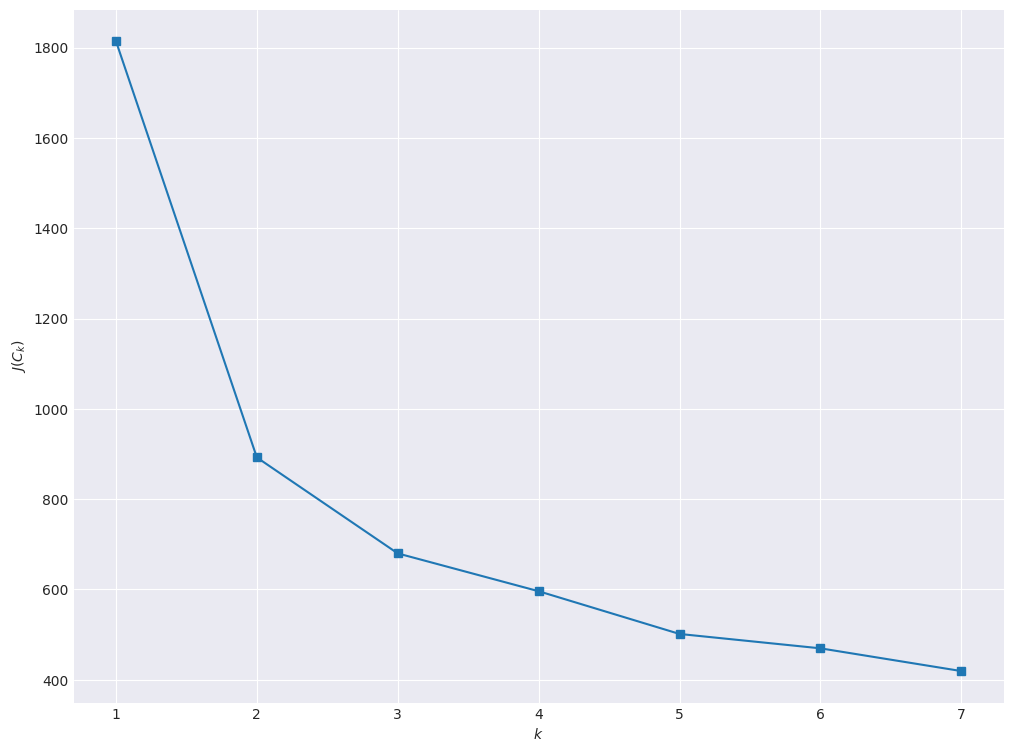

In [178]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(X_reduced)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

In [186]:
d = [[]]
ine = inertia
di = (ine[4] - ine[5]) / (ine[3] - ine[4])
print(di)

0.3364239429730389


Answer: 2 elbow. You can see on formula, that are our goal decrease/minimize a D(k)

In [187]:
from sklearn.cluster import AgglomerativeClustering as AgC

In [188]:
ag = AgC(n_clusters=n_classes,linkage='ward').fit(X_reduced)

In [192]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(y, ag.labels_)

0.2625750496345055

In [191]:
adjusted_rand_score(y, kmeans.labels_)

0.25411911250837665

In [196]:
%%time
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

svc = LinearSVC(random_state=RANDOM_STATE)
svc_p =  {"C" : [0.001, 0.01, 0.1, 1, 10]}
LinearSVC = GridSearchCV(svc, svc_p, cv=3)
LinearSVC.fit(SS.fit_transform(X_train), y_train)


c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

CPU times: total: 40.9 s
Wall time: 41 s


c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [199]:
LinearSVC.best_params_ 

{'C': 0.1}

In [200]:
LinearSVC.best_score_

0.9382506099134881

Which value of the hyperparameter C was chosen the best on the basis of cross-validation?  {'C': 0.1} score: 0.9382506099134881

In [204]:
pred = LinearSVC.best_estimator_.predict(SS.fit_transform(X_test))

In [205]:
tab = pd.crosstab(y_test, pred, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,479,11,4,2,0,0,496
climbing up the stairs,4,465,1,1,0,0,471
going down the stairs,1,2,416,1,0,0,420
sitting,0,4,0,433,52,2,491
standing,0,0,0,16,516,0,532
laying,0,0,0,0,6,531,537
all,484,482,421,453,574,533,2947


In [218]:
print("going up the stairs pre recall laying %", (465 / 471), (531 / 533))
print(" laying pre recall sitting %", (531 / 537), (433 / 453))
print("walking pre recall walking %", (479 / 496), (479 / 484))
print(" standing pre recall sitting %", (516 / 532), (433 / 453))

going up the stairs pre recall laying % 0.9872611464968153 0.9962476547842402
 laying pre recall sitting % 0.9888268156424581 0.9558498896247241
walking pre recall walking % 0.9657258064516129 0.9896694214876033
 standing pre recall sitting % 0.9699248120300752 0.9558498896247241


answer walking-walking

In [226]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svc2 = LinearSVC(random_state=RANDOM_STATE)
svc_p = {"C": [0.001, 0.01, 0.1, 1, 10]}

best_svc_pca = GridSearchCV(svc2, svc_p, n_jobs=4, cv=3, verbose=1)
best_svc_pca.fit(X_train_pca, y_train)

best_svc_pca.best_params_, best_svc_pca.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\nuke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


({'C': 1}, 0.8998943094169531)

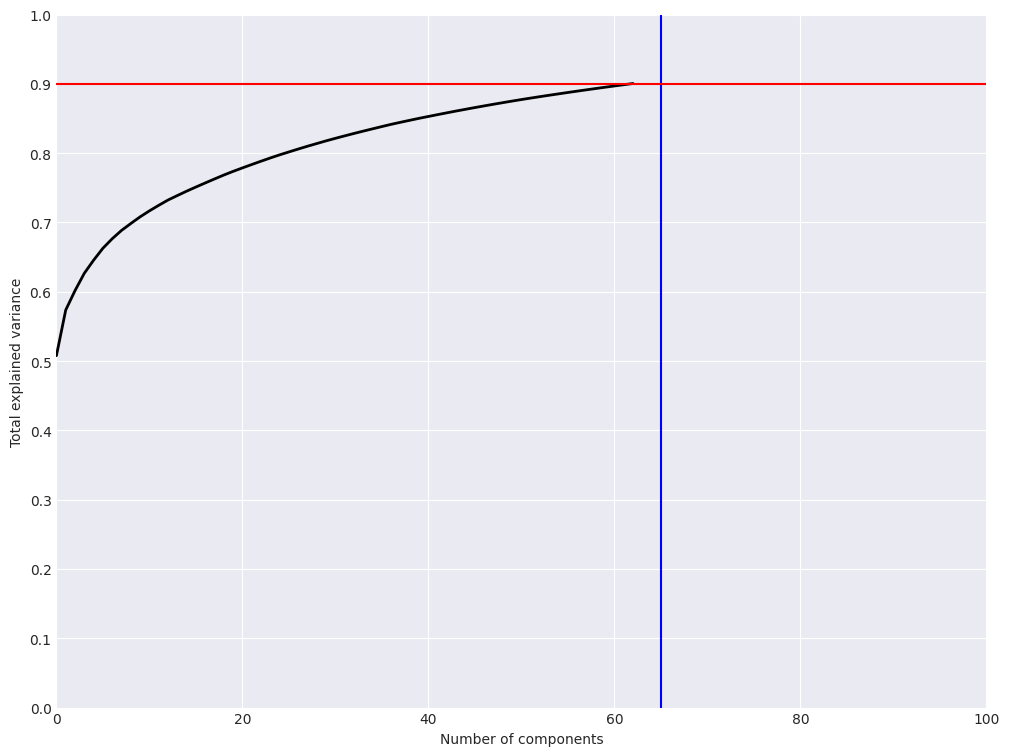

In [227]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), color="k", lw=2)
plt.xlabel("Number of components")
plt.ylabel("Total explained variance")
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(65, c="b")
plt.axhline(0.9, c="r")
plt.show();